In [1]:
from moist_konrad_tests import *
import matplotlib.pyplot as plt
import numpy as np

In [2]:
plev, phlev = konrad.utils.get_pressure_grids(1000e2, 100, 128)
atmosphere = konrad.atmosphere.Atmosphere(phlev)
clearsky = konrad.cloud.ClearSky.from_atmosphere(atmosphere)
surface = konrad.surface.SlabOcean(
    temperature=288,
    heat_sink=0,
    depth = 50,
    albedo = 0.5)

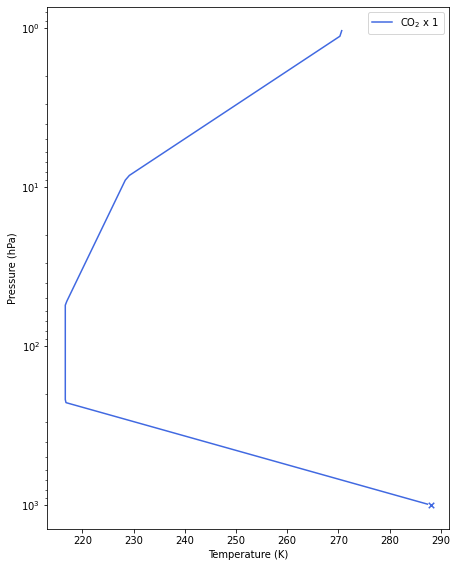

In [3]:
fig, ax = plt.subplots(figsize=(1.5*4.8, 1.5*6.4))


ax.plot(atmosphere['T'][0], atmosphere['plev']/100,
               alpha = 1, color = 'royalblue', lw = 1.5, label = 'CO$_2$ x 1')
ax.scatter(surface['temperature'], atmosphere['phlev'][0]/100,
               alpha = 1, color = 'royalblue', s = 30, marker ='x')

ax.set_yscale('log')
ax.yaxis.set_inverted(True)
ax.set_xlabel('Temperature (K)')
ax.set_ylabel('Pressure (hPa)')

plt.legend()
plt.show()

In [4]:
plev, phlev = konrad.utils.get_pressure_grids(1000e2, 100, 128)
atmosphere = konrad.atmosphere.Atmosphere(phlev)
clearsky = konrad.cloud.ClearSky.from_atmosphere(atmosphere)
surface = konrad.surface.SlabOcean(
    temperature=288,
    heat_sink=0,
    depth = 50,
    albedo = 0.5)

surface['temperature'] = np.array([295.])
atmosphere['T'][0] = moist_adiabat(surface['temperature'],atmosphere['T'][0],atmosphere)


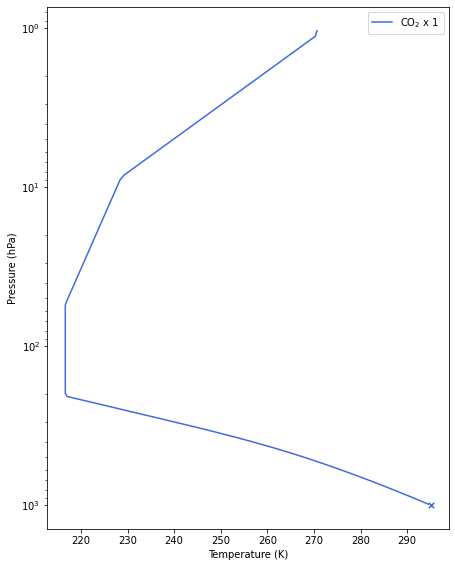

In [5]:
fig, ax = plt.subplots(figsize=(1.5*4.8, 1.5*6.4))


ax.plot(atmosphere['T'][0], atmosphere['plev']/100,
               alpha = 1, color = 'royalblue', lw = 1.5, label = 'CO$_2$ x 1')
ax.scatter(surface['temperature'], atmosphere['phlev'][0]/100,
               alpha = 1, color = 'royalblue', s = 30, marker ='x')

ax.set_yscale('log')
ax.yaxis.set_inverted(True)
ax.set_xlabel('Temperature (K)')
ax.set_ylabel('Pressure (hPa)')

plt.legend()
plt.show()

In [6]:
###PARAMETERS OF THE TEST:

#flux for efficiency computation:
# 1: LH + SH
# 2: Radiation surface
# 3: Atmosphere radiation

F_case = 1

#coupled surface-atmosphere: 
#if true, surface fluxes and surface temperature change at each step, constant otherwise
coupled = True

SH_f = 30.
LH_f = 100.

Ts_f = np.array([305.])
RLS = 1/1

#Strong coupling surface-atmosphere:
#If true the atmosphere moist adiabat starts at surface temperature
#If false find the atmopsheric moist adiabat that conserves energy
strong = False

popke = False
if popke == True:
    solar = 510.
    angle = 47.9
else:
    solar = 480.
    angle = 42.05

A = 0.2

In [7]:
### INITIALIZATION
E_imbalance = 0.

plev, phlev = konrad.utils.get_pressure_grids(1000e2, 100, 128)
atmosphere = konrad.atmosphere.Atmosphere(phlev)
clearsky = konrad.cloud.ClearSky.from_atmosphere(atmosphere)
surface = konrad.surface.SlabOcean(
    temperature=288,
    heat_sink=0,
    depth = 50,
    albedo = 0.5)

radiation = konrad.radiation.RRTMG(solar_constant=solar, zenith_angle = angle)

ndays = 10000
timestep = 0.5 #days
nsteps = int(ndays/timestep)

printcounter = 0
status = 0

tol = 1e-5

dE_1 = [1e8]
OLR_1 = [1e8]
NSW_1 = [1e8]
T_sfc_1 = [1e8,1e7]
toa_1 = [1e8,1e7]
T_low_1 = [1e8]
atm_rad_1 = [1e8]
sfc_rad_1 = [1e8]
SH_1 = [1e8]
LH_1 = [1e8]
PH_1 = [1e8]

In [8]:
%%time
### RCPE COMPUTATION

surface['temperature'] = Ts_f
surface.albedo = A
print(surface['temperature'],surface.albedo)

conv_top = coldpoint(atmosphere['T'][0])
RH = manabe_rh(0.77,atmosphere['plev'])
atmosphere['H2O'][0] = rh_to_vmr(RH,atmosphere['T'][0],atmosphere['plev'],conv_top)
T_atm_low = surface['temperature']

print(surface['temperature'],surface.albedo)

#### RCE FOR PRESENT-DAY CO2
atmosphere['CO2'][0] = 348/1e6

day = 1
for i in range(nsteps):
    #surface fluxes
    z = height(atmosphere['plev'],atmosphere['T'][0],
               atmosphere['phlev'][0],surface['temperature'])
    zini = 2
    
    T_ini,vmr_ini = T_vmr_z(T_atm_low,atmosphere['T'][0][0].copy(),
                            atmosphere['H2O'][0,0].copy(),atmosphere['H2O'][0,1].copy(),
                            z,zini)
#    T_ini = atmosphere['T'][0][0].copy()
#    vmr_ini = atmosphere['H2O'][0,0].copy()
    
    #compute the fluxes or input the forcing
    if coupled == True:
        LH = latent_heat(vmr_ini, T_ini,atmosphere['phlev'][0],RLS)
        SH = sensible_heat(T_ini,surface['temperature'],atmosphere['phlev'][0],RLS)
        
    else:
        LH = LH_f
        SH = SH_f
        
    
    #convective adjustment of the armosphere
    
    atmosphere,surface,radiation,net_rad_surface,atm_rad,\
    T_atm_low,E_imbalance,prec_mass,prec_heating,\
    RH,cold_point,prec_eff = RCPE_step_DSE(timestep,
                                          atmosphere,surface,radiation,clearsky,
                                          SH,LH,surface.albedo,T_atm_low,
                                          strong_coupling = strong,
                                          constrain_RH = True,
                                        Flux_case = F_case)
    
    
    #update surface temperature with energetic fluxes (latent and radiative)
    if coupled == True:
        surface['temperature'] = surface['temperature'] + ((net_rad_surface - SH - LH)
                               * seconds_day * timestep / surface.heat_capacity)
    
    else:
        surface['temperature'] = Ts_f
    
    
    
    status += 1
    if printcounter == 200:
        print(status*timestep)
        printcounter = 0
        Flux = np.maximum(net_rad_surface,np.maximum(abs(atm_rad),SH+LH))
        Flux = LH+abs(SH)
        # Flux = (abs(atm_rad)+SH+LH+net_rad_surface)/3
        prec_eff = np.maximum(0.,np.minimum(1.,LH/Flux))
        prec_eff = LH/Flux
        print(surface['temperature'],SH,LH,prec_mass*Lv/seconds_day,
              E_imbalance,prec_eff)
        print(RH[0])
        print(T_atm_low,T_ini)
    printcounter += 1

    
    dE_1.append(E_imbalance.copy())
    OLR_1.append(radiation['lw_flxu'][0,-1].copy() - radiation['lw_flxd'][0,-1].copy())
    NSW_1.append(radiation['sw_flxd'][0,-1].copy() - radiation['sw_flxu'][0,-1].copy())
    T_sfc_1.append(surface['temperature'])
    toa_1.append(radiation['toa'].copy())
    T_low_1.append(T_ini.copy())
    atm_rad_1.append(atm_rad.copy())
    sfc_rad_1.append(net_rad_surface.copy())
    SH_1.append(SH)
    LH_1.append(LH)
    PH_1.append(prec_mass.copy()*Lv/seconds_day)
    
    T_present = (T_sfc_1[i]+T_sfc_1[i-1])/2.
    T_past = (T_sfc_1[i-1]+T_sfc_1[i-2])/2.
    toa_present = (toa_1[i]+toa_1[i-1])/2.
    toa_past = (toa_1[i-1]+toa_1[i-2])/2.
    if abs(T_present - T_past)<tol and abs(toa_present - toa_past)<tol:
        print(i)
        break
    
    
### Record RCE 1xCO2
RH_1 = RH.copy()
Mw_1 = column_water_mass(atmosphere['H2O'][0],atmosphere['phlev']).copy()
vmr_1 = atmosphere['H2O'][0].copy()
T_atm_1 = atmosphere['T'][0].copy()
Prec_1 = prec_mass.copy()

[305.] 0.2
[305.] 0.2
100.5
[303.5653312] [75.00980184] [89.78207741] [89.90356601] [-0.00073677] [0.54482101]
0.9187834057923262
[300.35478113] [300.34770221]
200.5
[303.36824529] [71.45298983] [93.5346648] [93.65963809] [-0.00098534] [0.56691917]
0.9157747361172005
[300.31074128] [300.30367388]
300.5
[303.17299741] [67.84101844] [97.38355129] [97.50443358] [-0.00135078] [0.58940115]
0.9126941076560805
[300.2708659] [300.26376867]
400.5
[302.97913881] [64.14109012] [101.34350033] [101.45849075] [-0.00181358] [0.61240445]
0.9095375593433846
[300.23606671] [300.22894005]
500.5
[302.78634542] [60.36397864] [105.39651805] [105.50583179] [-0.00012733] [0.63583616]
0.9063168717876328
[300.20557367] [300.19841526]
600.5
[302.59422713] [56.48644499] [109.58845341] [109.69304862] [-0.00015892] [0.65987367]
0.9030021477369647
[300.17998456] [300.17280058]
700.5
[302.40255253] [52.53865086] [113.8614015] [113.96009423] [-0.00019273] [0.68426301]
0.899633056456697
[300.15779586] [300.15059021]
80

6000.5
[298.17715423] [4.8011231] [155.6537137] [155.66028685] [-0.00068336] [0.97007804]
0.8523441580577721
[297.98042153] [297.9728006]
6100.5
[298.17133569] [4.80137498] [155.62595287] [155.632783] [-0.000681] [0.97007134]
0.8523239048240561
[297.97459682] [297.96697291]
6200.5
[298.16596256] [4.80158966] [155.60504297] [155.61147313] [-0.00068168] [0.97006614]
0.8523012297138135
[297.96921963] [297.96159196]
6300.5
[298.16101909] [4.80170049] [155.58433805] [155.59038488] [-0.00068367] [0.97006161]
0.8522817306812749
[297.96427547] [297.95664523]
6400.5
[298.15643758] [4.80182917] [155.56396625] [155.56951117] [-0.00068369] [0.97005702]
0.8522647073502897
[297.95969241] [297.95205966]
6500.5
[298.15221448] [4.8021643] [155.54171336] [155.5459778] [-0.00068399] [0.97005084]
0.8522521175685545
[297.95545985] [297.94782368]
6600.5
[298.1483035] [4.8019221] [155.51686207] [155.52099173] [-0.00068177] [0.97004766]
0.8522441449379907
[297.95156143] [297.94392409]
6700.5
[298.14469762] [4

In [9]:
print('P',Prec_1)
print('LH',LH_1[-1])
print('SH',SH_1[-1])
print('R_sfc',sfc_rad_1[-1])
print('R_sfc-LH-SH',sfc_rad_1[-1]-SH_1[-1]-LH_1[-1])
print('R_atm', atm_rad_1[-1])
print('R_atm+SH+LP', atm_rad_1[-1] + SH_1[-1] + Lv*Prec_1/seconds_day)
print('toa indirect',sfc_rad_1[-1]+atm_rad_1[-1])
print('toa direct',toa_1[-1])
print('Energy imbalance',dE_1[-1])
print('Energy imbalance in mm/day', dE_1[-1]/Lv *seconds_day)
print('E',LH_1[-1]/Lv * seconds_day)
print('RH_surface',RH_1[0])
print('T_sfc',T_sfc_1[-1])
print('T_atm low',T_low_1[-1])
print('WVP',Mw_1)

P [5.36892869]
LH [155.41057364]
SH [4.8026268]
R_sfc 160.16423075778562
R_sfc-LH-SH [-0.04896968]
R_atm -160.21967652445528
R_atm+SH+LP [-0.0039635]
toa indirect -0.0554457666696635
toa direct [-0.05544577]
Energy imbalance [-0.00068217]
Energy imbalance in mm/day [-2.35664611e-05]
E [5.36884189]
RH_surface 0.8521692708292415
T_sfc [298.12627751]
T_atm low [297.92187418]
WVP 50.876034294701896


/home/lluc/miniforge3/envs/konrad-env/lib/python3.6/site-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  after removing the cwd from sys.path.


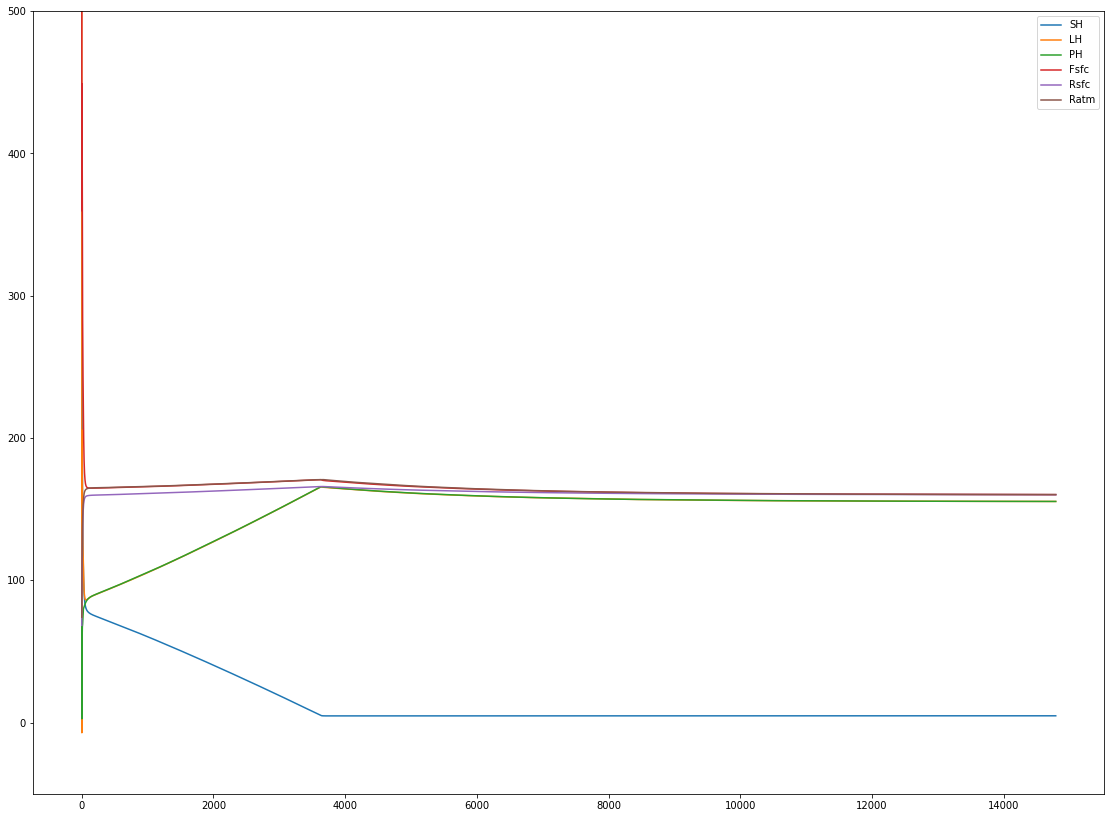

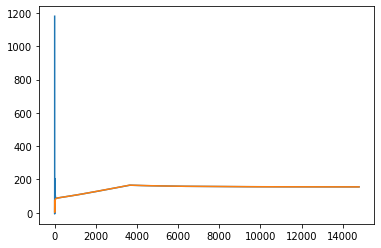

In [10]:
fig, ax = plt.subplots(figsize=(3*6.4, 3*4.8))
SH = np.array(SH_1[1:])
PH = np.array(PH_1[1:])
LH = np.array(LH_1[1:])
Fsfc = np.zeros((len(LH)))
for i in range(len(LH)):
    Fsfc[i] = SH[i] + LH[i]
Rsfc = np.array(sfc_rad_1[1:])
Ratm = np.array(atm_rad_1[1:])

plt.plot(SH[:],label='SH')
plt.plot(LH[:],label='LH')
plt.plot(PH[:],label='PH')
plt.plot(Fsfc[:],label='Fsfc')
plt.plot(Rsfc[:],label='Rsfc')
plt.plot(-Ratm[:],label='Ratm')
plt.ylim(-50,500)
plt.legend()
plt.show()

plt.plot(LH[:],label='LH')
plt.plot(PH[:],label='PH')
plt.show()

/home/lluc/miniforge3/envs/konrad-env/lib/python3.6/site-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


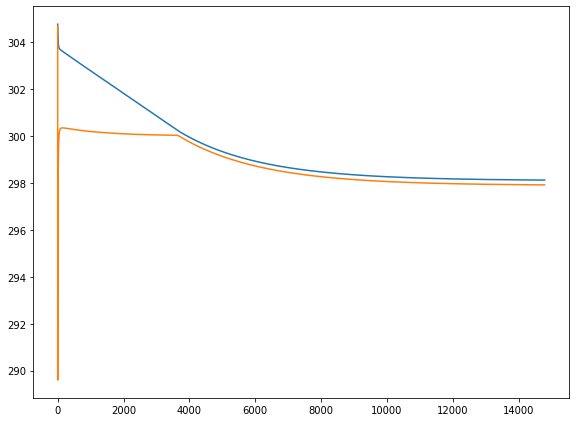

In [11]:
fig, ax = plt.subplots(figsize=(1.5*6.4, 1.5*4.8))
T_sfc_rec = np.array(T_sfc_1[2:])
T_low_rec = np.array(T_low_1[1:])
plt.plot(T_sfc_rec)
plt.plot(T_low_rec)
plt.show()

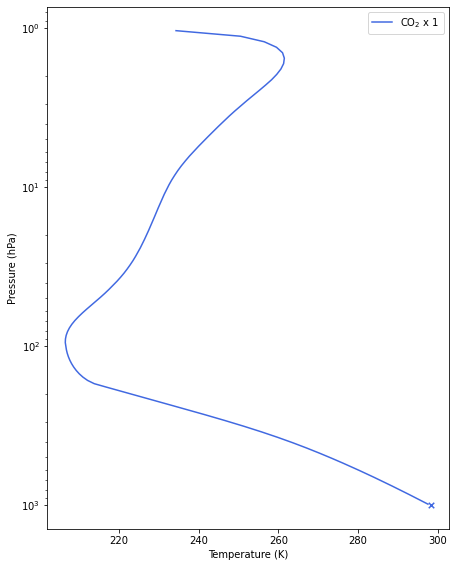

In [12]:
fig, ax = plt.subplots(figsize=(1.5*4.8, 1.5*6.4))


ax.plot(T_atm_1, atmosphere['plev']/100,
               alpha = 1, color = 'royalblue', lw = 1.5, label = 'CO$_2$ x 1')
ax.scatter(T_sfc_1[-1], atmosphere['phlev'][0]/100,
               alpha = 1, color = 'royalblue', s = 30, marker ='x')

ax.set_yscale('log')
ax.yaxis.set_inverted(True)
ax.set_xlabel('Temperature (K)')
ax.set_ylabel('Pressure (hPa)')

plt.legend()
plt.show()

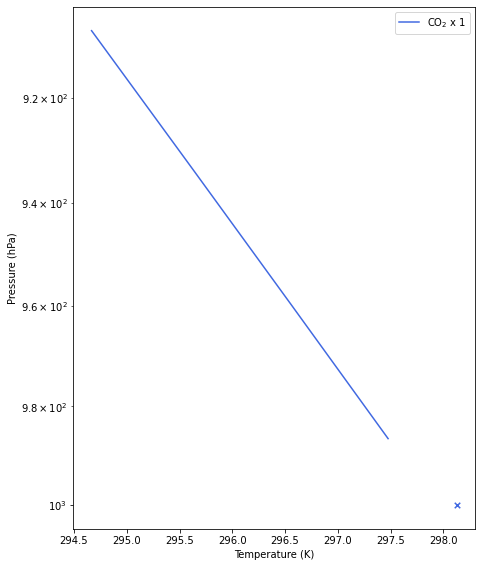

In [13]:
fig, ax = plt.subplots(figsize=(1.5*4.8, 1.5*6.4))

bot = 0
top = 4

ax.plot(T_atm_1[bot:top], atmosphere['plev'][bot:top]/100,
               alpha = 1, color = 'royalblue', lw = 1.5, label = 'CO$_2$ x 1')
ax.scatter(T_sfc_1[-1], atmosphere['phlev'][0]/100,
               alpha = 1, color = 'royalblue', s = 30, marker ='x')

ax.set_yscale('log')
ax.yaxis.set_inverted(True)
ax.set_xlabel('Temperature (K)')
ax.set_ylabel('Pressure (hPa)')

plt.legend()
plt.show()